In [1]:
import pandas as pd
from sklearn.datasets import make_regression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import geopy.distance
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import *

In [2]:
train_file = 'data/out/train_cleaned.csv'
test_file = 'data/out/test_cleaned.csv'

In [3]:
train_data = pd.read_csv(train_file)
train_data.drop(columns=['Unnamed: 0'],axis=1,inplace=True)
test_data = pd.read_csv(test_file)
test_data.drop(columns=['Unnamed: 0'],axis=1,inplace=True)

In [4]:
train_data.head()

,id,fecha,latitud_origen,longitud_origen,latitud_destino,longitud_destino,distancia,tiempo,distancia_api,tiempo_api,...,region_destino_Lima,region_destino_Loreto,region_destino_Madre de Dios,region_destino_Moquegua,region_destino_Pasco,region_destino_Puno,region_destino_San Martín,region_destino_Tacna,region_destino_Tumbes,region_destino_Ucayali
0,124092420,2021-07-28,-11.965070,-77.12269,-12.07020,-77.13524,14747.0,1775.0,13573.1,1285.1,...,1,0,0,0,0,0,0,0,0,0
1,124091219,2021-07-25,-12.155090,-76.97996,-12.07570,-76.91754,17171.0,1821.0,14549.1,1210.1,...,1,0,0,0,0,0,0,0,0,0
2,124091187,2021-07-25,-14.533770,-75.18460,-14.88630,-74.99414,58708.0,3842.0,58253.0,3680.0,...,0,0,0,0,0,0,0,0,0,0
3,124093495,2021-08-01,-5.201517,-80.64635,-5.38453,-80.62314,23611.0,1446.0,23597.4,1472.8,...,0,0,0,0,0,0,0,0,0,0
4,124092156,2021-07-27,-11.967470,-77.12508,-12.03500,-77.07444,14229.0,1974.0,14608.3,1154.8,...,1,0,0,0,0,0,0,0,0,0


In [5]:
test_data.head()

,id,fecha,latitud_origen,longitud_origen,latitud_destino,longitud_destino,distancia_api,tiempo_api,region_origen_Amazonas,region_origen_Ancash,...,region_destino_Lima,region_destino_Loreto,region_destino_Madre de Dios,region_destino_Moquegua,region_destino_Pasco,region_destino_Puno,region_destino_San Martín,region_destino_Tacna,region_destino_Tumbes,region_destino_Ucayali
0,124089165,2021-07-20,-12.781050,-74.99228,-12.76703,-74.64612,76381.7,4891.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,124093149,2021-07-31,-7.140513,-78.51395,-7.58284,-78.07524,124606.8,10232.9,0,0,...,0,0,0,0,0,0,0,0,0,0
2,124090750,2021-07-24,-12.010250,-77.11206,-11.99380,-77.02614,20630.3,1631.7,0,0,...,1,0,0,0,0,0,0,0,0,0
3,124092491,2021-07-29,-12.155750,-76.97977,-12.22090,-76.91364,12105.8,1067.6,0,0,...,1,0,0,0,0,0,0,0,0,0
4,124091871,2021-07-27,-12.114920,-77.04678,-12.07910,-77.11724,9403.2,652.5,0,0,...,1,0,0,0,0,0,0,0,0,0


In [6]:
train_data.shape

(1952, 59)

In [7]:
test_data.shape

(852, 57)

In [8]:
X=train_data.loc[:,train_data.columns.isin(['id','fecha','distancia','tiempo']) == False].values
y=train_data.iloc[:,6:8].values
yhat=test_data.iloc[:,2:].values

In [9]:
from sklearn import preprocessing
preprocessing.minmax_scale(X)
preprocessing.minmax_scale(yhat)

array([[0.36037929, 0.52007466, 0.36614227, ..., 0.        , 0.        ,
        0.        ],
       [0.74842017, 0.22806174, 0.72358461, ..., 0.        , 0.        ,
        0.        ],
       [0.4134065 , 0.34430488, 0.41945535, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.40340095, 0.3552709 , 0.41559216, ..., 0.        , 0.        ,
        0.        ],
       [0.40340026, 0.3552709 , 0.42098601, ..., 0.        , 0.        ,
        0.        ],
       [0.15010318, 0.93230005, 0.23882396, ..., 0.        , 0.        ,
        0.        ]])

In [10]:
from keras.optimizers import Adam
from keras.layers import LeakyReLU

def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(256, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(128, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(64, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(32, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(16, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(8, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(4, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    model.compile(loss='mape', optimizer=Adam(learning_rate=1e-4))
    return model

In [11]:
n_inputs, n_outputs = X.shape[1], y.shape[1]
print(X.shape[1], y.shape[1])

55 2


In [12]:
from keras.callbacks import ModelCheckpoint

def get_callbacks():
    filepath = 'data/out/try8.h5'
    callback1 = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
    callback2 = CSVLogger('data/out/try8.csv')
    
    return [callback1,callback2]

In [13]:
model = get_model(n_inputs, n_outputs)
history = model.fit(X, y, verbose=1, epochs=1000, validation_split=0.2, callbacks=get_callbacks())

Epoch 1/1000
49/49 [==============================] - 2s 20ms/step - loss: 194.4583 - val_loss: 71.0040

Epoch 00001: loss improved from inf to 127.66927, saving model to data/out\try8.h5
Epoch 2/1000
49/49 [==============================] - 0s 2ms/step - loss: 71.2185 - val_loss: 69.8508

Epoch 00002: loss improved from 127.66927 to 71.16112, saving model to data/out\try8.h5
Epoch 3/1000
49/49 [==============================] - 0s 2ms/step - loss: 70.0799 - val_loss: 69.1666

Epoch 00003: loss improved from 71.16112 to 70.07833, saving model to data/out\try8.h5
Epoch 4/1000
49/49 [==============================] - 0s 2ms/step - loss: 69.2253 - val_loss: 66.9381

Epoch 00004: loss improved from 70.07833 to 68.80875, saving model to data/out\try8.h5
Epoch 5/1000
49/49 [==============================] - 0s 2ms/step - loss: 66.8960 - val_loss: 66.1036

Epoch 00005: loss improved from 68.80875 to 66.69344, saving model to data/out\try8.h5
Epoch 6/1000
49/49 [==============================]

49/49 [==============================] - 0s 2ms/step - loss: 62.3116 - val_loss: 62.5866

Epoch 00048: loss improved from 62.20818 to 62.15784, saving model to data/out\try8.h5
Epoch 49/1000
49/49 [==============================] - 0s 2ms/step - loss: 61.8544 - val_loss: 63.3229

Epoch 00049: loss improved from 62.15784 to 62.05975, saving model to data/out\try8.h5
Epoch 50/1000
49/49 [==============================] - 0s 2ms/step - loss: 62.4140 - val_loss: 62.4176

Epoch 00050: loss did not improve from 62.05975
Epoch 51/1000
49/49 [==============================] - 0s 2ms/step - loss: 61.8488 - val_loss: 62.3369

Epoch 00051: loss improved from 62.05975 to 61.88341, saving model to data/out\try8.h5
Epoch 52/1000
49/49 [==============================] - 0s 2ms/step - loss: 61.8173 - val_loss: 63.3675

Epoch 00052: loss improved from 61.88341 to 61.78196, saving model to data/out\try8.h5
Epoch 53/1000
49/49 [==============================] - 0s 2ms/step - loss: 62.2290 - val_loss: 62.

49/49 [==============================] - 0s 2ms/step - loss: 12.2316 - val_loss: 13.3293

Epoch 00096: loss did not improve from 12.29385
Epoch 97/1000
49/49 [==============================] - 0s 2ms/step - loss: 12.5673 - val_loss: 13.7658

Epoch 00097: loss did not improve from 12.29385
Epoch 98/1000
49/49 [==============================] - 0s 2ms/step - loss: 12.5100 - val_loss: 15.7748

Epoch 00098: loss did not improve from 12.29385
Epoch 99/1000
49/49 [==============================] - 0s 2ms/step - loss: 13.4397 - val_loss: 13.1287

Epoch 00099: loss did not improve from 12.29385
Epoch 100/1000
49/49 [==============================] - 0s 2ms/step - loss: 12.1116 - val_loss: 13.9576

Epoch 00100: loss did not improve from 12.29385
Epoch 101/1000
49/49 [==============================] - 0s 2ms/step - loss: 12.2751 - val_loss: 14.0376

Epoch 00101: loss did not improve from 12.29385
Epoch 102/1000
49/49 [==============================] - 0s 2ms/step - loss: 12.5260 - val_loss: 13.3

49/49 [==============================] - 0s 2ms/step - loss: 12.9288 - val_loss: 13.2538

Epoch 00149: loss did not improve from 12.12302
Epoch 150/1000
49/49 [==============================] - 0s 2ms/step - loss: 12.5086 - val_loss: 14.5088

Epoch 00150: loss did not improve from 12.12302
Epoch 151/1000
49/49 [==============================] - 0s 2ms/step - loss: 12.4999 - val_loss: 13.0718

Epoch 00151: loss did not improve from 12.12302
Epoch 152/1000
49/49 [==============================] - 0s 2ms/step - loss: 12.1786 - val_loss: 13.3840

Epoch 00152: loss did not improve from 12.12302
Epoch 153/1000
49/49 [==============================] - 0s 2ms/step - loss: 12.2117 - val_loss: 13.2844

Epoch 00153: loss did not improve from 12.12302
Epoch 154/1000
49/49 [==============================] - 0s 2ms/step - loss: 12.4812 - val_loss: 12.9972

Epoch 00154: loss did not improve from 12.12302
Epoch 155/1000
49/49 [==============================] - 0s 2ms/step - loss: 12.2255 - val_loss: 1


Epoch 00201: loss did not improve from 11.93692
Epoch 202/1000
49/49 [==============================] - 0s 2ms/step - loss: 12.7440 - val_loss: 13.7390

Epoch 00202: loss did not improve from 11.93692
Epoch 203/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.9353 - val_loss: 13.3802

Epoch 00203: loss did not improve from 11.93692
Epoch 204/1000
49/49 [==============================] - 0s 2ms/step - loss: 12.6841 - val_loss: 12.8390

Epoch 00204: loss did not improve from 11.93692
Epoch 205/1000
49/49 [==============================] - 0s 2ms/step - loss: 12.1012 - val_loss: 13.0129

Epoch 00205: loss did not improve from 11.93692
Epoch 206/1000
49/49 [==============================] - 0s 2ms/step - loss: 12.0383 - val_loss: 12.8784

Epoch 00206: loss did not improve from 11.93692
Epoch 207/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.9219 - val_loss: 12.9361

Epoch 00207: loss did not improve from 11.93692
Epoch 208/1000
49/49 [===========

49/49 [==============================] - 0s 2ms/step - loss: 12.7923 - val_loss: 12.8376

Epoch 00254: loss did not improve from 11.90443
Epoch 255/1000
49/49 [==============================] - 0s 2ms/step - loss: 12.7928 - val_loss: 12.7657

Epoch 00255: loss did not improve from 11.90443
Epoch 256/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.9969 - val_loss: 12.8517

Epoch 00256: loss did not improve from 11.90443
Epoch 257/1000
49/49 [==============================] - 0s 2ms/step - loss: 12.5632 - val_loss: 12.8985

Epoch 00257: loss did not improve from 11.90443
Epoch 258/1000
49/49 [==============================] - 0s 2ms/step - loss: 12.8377 - val_loss: 13.0292

Epoch 00258: loss did not improve from 11.90443
Epoch 259/1000
49/49 [==============================] - 0s 2ms/step - loss: 12.0198 - val_loss: 13.1260

Epoch 00259: loss did not improve from 11.90443
Epoch 260/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.9911 - val_loss: 1

49/49 [==============================] - 0s 2ms/step - loss: 12.6606 - val_loss: 12.6231

Epoch 00306: loss did not improve from 11.82634
Epoch 307/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.6654 - val_loss: 12.7257

Epoch 00307: loss did not improve from 11.82634
Epoch 308/1000
49/49 [==============================] - 0s 2ms/step - loss: 12.4609 - val_loss: 13.9351

Epoch 00308: loss did not improve from 11.82634
Epoch 309/1000
49/49 [==============================] - 0s 2ms/step - loss: 12.6441 - val_loss: 12.6500

Epoch 00309: loss did not improve from 11.82634
Epoch 310/1000
49/49 [==============================] - 0s 2ms/step - loss: 12.0978 - val_loss: 13.1758

Epoch 00310: loss did not improve from 11.82634
Epoch 311/1000
49/49 [==============================] - 0s 2ms/step - loss: 12.2318 - val_loss: 12.6922

Epoch 00311: loss did not improve from 11.82634
Epoch 312/1000
49/49 [==============================] - 0s 2ms/step - loss: 12.5451 - val_loss: 1

49/49 [==============================] - 0s 2ms/step - loss: 11.8262 - val_loss: 12.6745

Epoch 00359: loss did not improve from 11.75162
Epoch 360/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.7846 - val_loss: 12.5694

Epoch 00360: loss did not improve from 11.75162
Epoch 361/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.2608 - val_loss: 12.8039

Epoch 00361: loss improved from 11.75162 to 11.67386, saving model to data/out\try8.h5
Epoch 362/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.8410 - val_loss: 12.6695

Epoch 00362: loss did not improve from 11.67386
Epoch 363/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.7169 - val_loss: 12.6388

Epoch 00363: loss did not improve from 11.67386
Epoch 364/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.5902 - val_loss: 12.6677

Epoch 00364: loss did not improve from 11.67386
Epoch 365/1000
49/49 [==============================] - 0s

49/49 [==============================] - 0s 2ms/step - loss: 11.8057 - val_loss: 12.5002

Epoch 00412: loss did not improve from 11.67386
Epoch 413/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.8524 - val_loss: 12.8288

Epoch 00413: loss did not improve from 11.67386
Epoch 414/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.4648 - val_loss: 13.0596

Epoch 00414: loss did not improve from 11.67386
Epoch 415/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.7276 - val_loss: 12.6392

Epoch 00415: loss did not improve from 11.67386
Epoch 416/1000
49/49 [==============================] - 0s 2ms/step - loss: 12.1299 - val_loss: 12.8699

Epoch 00416: loss did not improve from 11.67386
Epoch 417/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.8688 - val_loss: 12.5562

Epoch 00417: loss did not improve from 11.67386
Epoch 418/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.8063 - val_loss: 1


Epoch 00464: loss did not improve from 11.61007
Epoch 465/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.6478 - val_loss: 12.3997

Epoch 00465: loss did not improve from 11.61007
Epoch 466/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.5235 - val_loss: 12.6428

Epoch 00466: loss did not improve from 11.61007
Epoch 467/1000
49/49 [==============================] - 0s 2ms/step - loss: 12.0802 - val_loss: 12.4132

Epoch 00467: loss did not improve from 11.61007
Epoch 468/1000
49/49 [==============================] - 0s 2ms/step - loss: 12.1623 - val_loss: 12.3887

Epoch 00468: loss did not improve from 11.61007
Epoch 469/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.8958 - val_loss: 12.9216

Epoch 00469: loss did not improve from 11.61007
Epoch 470/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.9579 - val_loss: 12.3910

Epoch 00470: loss did not improve from 11.61007
Epoch 471/1000
49/49 [===========

49/49 [==============================] - 0s 2ms/step - loss: 11.5525 - val_loss: 12.3091

Epoch 00517: loss did not improve from 11.46666
Epoch 518/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.3360 - val_loss: 12.4279

Epoch 00518: loss did not improve from 11.46666
Epoch 519/1000
49/49 [==============================] - 0s 2ms/step - loss: 12.0069 - val_loss: 12.4808

Epoch 00519: loss did not improve from 11.46666
Epoch 520/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.4347 - val_loss: 12.5702

Epoch 00520: loss did not improve from 11.46666
Epoch 521/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.9698 - val_loss: 12.3881

Epoch 00521: loss did not improve from 11.46666
Epoch 522/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.2233 - val_loss: 12.2897

Epoch 00522: loss did not improve from 11.46666
Epoch 523/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.4241 - val_loss: 1

49/49 [==============================] - 0s 2ms/step - loss: 11.6133 - val_loss: 12.3252

Epoch 00570: loss did not improve from 11.42220
Epoch 571/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.5712 - val_loss: 12.2118

Epoch 00571: loss did not improve from 11.42220
Epoch 572/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.3987 - val_loss: 12.2475

Epoch 00572: loss did not improve from 11.42220
Epoch 573/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.5285 - val_loss: 13.1186

Epoch 00573: loss did not improve from 11.42220
Epoch 574/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.0908 - val_loss: 12.3940

Epoch 00574: loss did not improve from 11.42220
Epoch 575/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.4622 - val_loss: 12.3727

Epoch 00575: loss did not improve from 11.42220
Epoch 576/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.1564 - val_loss: 1

49/49 [==============================] - 0s 2ms/step - loss: 11.0976 - val_loss: 12.1575

Epoch 00623: loss did not improve from 11.35445
Epoch 624/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.1371 - val_loss: 12.7854

Epoch 00624: loss did not improve from 11.35445
Epoch 625/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.5301 - val_loss: 12.0975

Epoch 00625: loss did not improve from 11.35445
Epoch 626/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.3160 - val_loss: 12.7843

Epoch 00626: loss did not improve from 11.35445
Epoch 627/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.5461 - val_loss: 12.4114

Epoch 00627: loss did not improve from 11.35445
Epoch 628/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.2390 - val_loss: 11.9948

Epoch 00628: loss did not improve from 11.35445
Epoch 629/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.5538 - val_loss: 1

49/49 [==============================] - 0s 2ms/step - loss: 11.3067 - val_loss: 12.0193

Epoch 00676: loss improved from 11.30568 to 11.29457, saving model to data/out\try8.h5
Epoch 677/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.2638 - val_loss: 12.2895

Epoch 00677: loss did not improve from 11.29457
Epoch 678/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.3720 - val_loss: 12.2190

Epoch 00678: loss did not improve from 11.29457
Epoch 679/1000
49/49 [==============================] - 0s 2ms/step - loss: 12.0039 - val_loss: 12.1403

Epoch 00679: loss did not improve from 11.29457
Epoch 680/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.6428 - val_loss: 12.0813

Epoch 00680: loss did not improve from 11.29457
Epoch 681/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.6764 - val_loss: 12.1560

Epoch 00681: loss did not improve from 11.29457
Epoch 682/1000
49/49 [==============================] - 0s

49/49 [==============================] - 0s 2ms/step - loss: 11.2965 - val_loss: 11.9499

Epoch 00729: loss did not improve from 11.24243
Epoch 730/1000
49/49 [==============================] - 0s 2ms/step - loss: 12.0344 - val_loss: 11.9891

Epoch 00730: loss did not improve from 11.24243
Epoch 731/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.3919 - val_loss: 12.6870

Epoch 00731: loss did not improve from 11.24243
Epoch 732/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.0486 - val_loss: 12.4768

Epoch 00732: loss did not improve from 11.24243
Epoch 733/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.7284 - val_loss: 12.1494

Epoch 00733: loss did not improve from 11.24243
Epoch 734/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.2227 - val_loss: 12.2218

Epoch 00734: loss improved from 11.24243 to 11.21000, saving model to data/out\try8.h5
Epoch 735/1000
49/49 [==============================] - 0s

49/49 [==============================] - 0s 2ms/step - loss: 11.0279 - val_loss: 12.0938

Epoch 00782: loss did not improve from 11.19523
Epoch 783/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.3438 - val_loss: 11.9379

Epoch 00783: loss did not improve from 11.19523
Epoch 784/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.1185 - val_loss: 11.9715

Epoch 00784: loss did not improve from 11.19523
Epoch 785/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.4455 - val_loss: 12.9661

Epoch 00785: loss did not improve from 11.19523
Epoch 786/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.2278 - val_loss: 11.9765

Epoch 00786: loss did not improve from 11.19523
Epoch 787/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.4529 - val_loss: 11.9285

Epoch 00787: loss did not improve from 11.19523
Epoch 788/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.2928 - val_loss: 1

49/49 [==============================] - 0s 2ms/step - loss: 11.7292 - val_loss: 12.5119

Epoch 00835: loss did not improve from 11.14665
Epoch 836/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.7579 - val_loss: 11.9249

Epoch 00836: loss did not improve from 11.14665
Epoch 837/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.4526 - val_loss: 11.8935

Epoch 00837: loss did not improve from 11.14665
Epoch 838/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.1767 - val_loss: 11.9825

Epoch 00838: loss did not improve from 11.14665
Epoch 839/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.1681 - val_loss: 12.0529

Epoch 00839: loss did not improve from 11.14665
Epoch 840/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.4317 - val_loss: 12.0056

Epoch 00840: loss did not improve from 11.14665
Epoch 841/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.0931 - val_loss: 1

49/49 [==============================] - 0s 2ms/step - loss: 11.3787 - val_loss: 11.8842

Epoch 00888: loss did not improve from 11.12533
Epoch 889/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.2611 - val_loss: 12.0514

Epoch 00889: loss did not improve from 11.12533
Epoch 890/1000
49/49 [==============================] - 0s 2ms/step - loss: 10.9788 - val_loss: 11.8382

Epoch 00890: loss did not improve from 11.12533
Epoch 891/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.0146 - val_loss: 12.0227

Epoch 00891: loss did not improve from 11.12533
Epoch 892/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.2253 - val_loss: 12.3607

Epoch 00892: loss did not improve from 11.12533
Epoch 893/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.6122 - val_loss: 11.8348

Epoch 00893: loss did not improve from 11.12533
Epoch 894/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.1936 - val_loss: 1

49/49 [==============================] - 0s 2ms/step - loss: 11.6428 - val_loss: 11.8409

Epoch 00941: loss did not improve from 11.10814
Epoch 942/1000
49/49 [==============================] - 0s 2ms/step - loss: 10.9304 - val_loss: 11.8545

Epoch 00942: loss did not improve from 11.10814
Epoch 943/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.3944 - val_loss: 12.8760

Epoch 00943: loss did not improve from 11.10814
Epoch 944/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.4320 - val_loss: 11.9898

Epoch 00944: loss did not improve from 11.10814
Epoch 945/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.0942 - val_loss: 12.3167

Epoch 00945: loss did not improve from 11.10814
Epoch 946/1000
49/49 [==============================] - 0s 2ms/step - loss: 10.9929 - val_loss: 12.2353

Epoch 00946: loss did not improve from 11.10814
Epoch 947/1000
49/49 [==============================] - 0s 2ms/step - loss: 10.8787 - val_loss: 1

49/49 [==============================] - 0s 2ms/step - loss: 11.6648 - val_loss: 11.7854

Epoch 00994: loss did not improve from 11.09154
Epoch 995/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.0056 - val_loss: 11.8228

Epoch 00995: loss improved from 11.09154 to 11.07142, saving model to data/out\try8.h5
Epoch 996/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.2768 - val_loss: 11.8793

Epoch 00996: loss did not improve from 11.07142
Epoch 997/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.6405 - val_loss: 11.9090

Epoch 00997: loss did not improve from 11.07142
Epoch 998/1000
49/49 [==============================] - 0s 2ms/step - loss: 11.0333 - val_loss: 11.8668

Epoch 00998: loss did not improve from 11.07142
Epoch 999/1000
49/49 [==============================] - 0s 2ms/step - loss: 10.8508 - val_loss: 11.9068

Epoch 00999: loss did not improve from 11.07142
Epoch 1000/1000
49/49 [==============================] - 0

In [14]:
#Cargando el mejor modelo

from keras.models import load_model
best_model_tf = load_model('data/out/try8.h5')

ypred = best_model_tf.predict(yhat)

In [15]:
print(ypred)

[[ 76959.61     5478.331 ]
 [126517.83    11162.245 ]
 [ 21279.309    2452.8733]
 ...
 [ 25067.67     2715.2512]
 [ 92885.98     7730.478 ]
 [167779.28    10614.337 ]]


In [16]:
best_model_tf.evaluate(X,y)

61/61 [==============================] - 0s 667us/step - loss: 11.1921


11.192073822021484

In [17]:
ids = pd.read_csv(test_file)
ids_1 = ids['id']

In [18]:
df = pd.DataFrame()
df['ID'] = ids_1
df['DISTANCIA'] = ypred[:,0]
df['TIEMPO'] = ypred[:,1]
print(df)

            ID      DISTANCIA        TIEMPO
0    124089165   76959.609375   5478.331055
1    124093149  126517.828125  11162.245117
2    124090750   21279.308594   2452.873291
3    124092491   12573.374023   1667.842773
4    124091871    9564.293945    965.621826
..         ...            ...           ...
847  124088805   15455.305664   2066.066895
848  124089757   12225.941406   1463.172241
849  124089569   25067.669922   2715.251221
850  124092518   92885.976562   7730.478027
851  124090644  167779.281250  10614.336914

[852 rows x 3 columns]


In [19]:
df.to_csv('data/out/try8_out.csv',index=False)

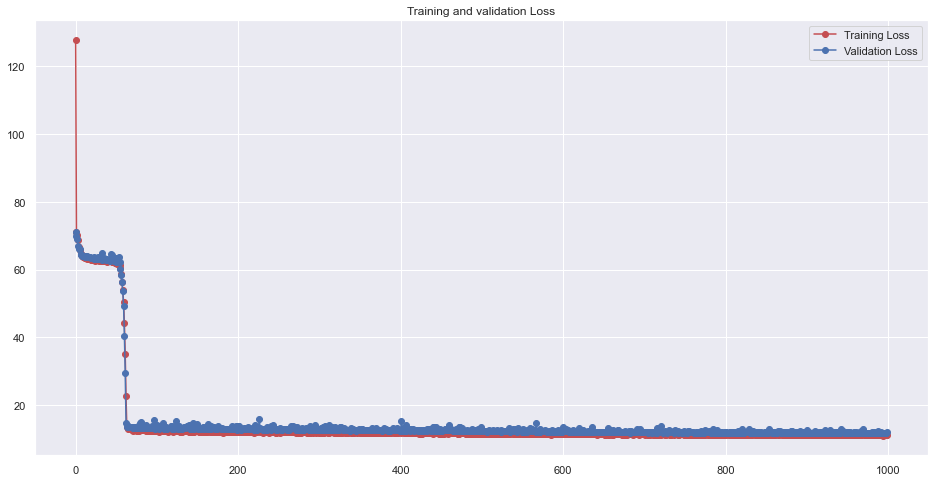

<Figure size 432x288 with 0 Axes>

In [20]:
#Graficar Epochs

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(0,len(loss))
fig = plt.gcf()
fig.set_size_inches(16, 8)

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.plot(epochs, loss, 'r', label='Training Loss',marker = "o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss',marker = "o")
plt.title('Training and validation Loss')
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()